In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
train_df = pd.read_csv("/content/product_trends_january_1000.csv")
test_df = pd.read_csv("/content/product_trends_february_1000.csv")

print(train_df.head())
print(test_df.head())


          product_name  search_volume  social_mentions  news_articles  \
0    Kindle Paperwhite             46             3749             88   
1        Gaming Laptop             30             9610             86   
2  Mechanical Keyboard             80             8095             72   
3  Retinol Night Cream             74             6794            131   
4      Sony WH-1000XM5             33             7027             86   

   sales_usd_million  influencer_mentions  sentiment_score  trend_score  \
0             199.40                  190             0.26           44   
1             278.92                  118            -0.62           50   
2             254.05                   95            -0.71           54   
3             100.96                   52             0.88           47   
4             430.11                   51             0.84           58   

   next_month_trend  
0                 0  
1                 0  
2                 0  
3                 0  


In [ ]:
train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)


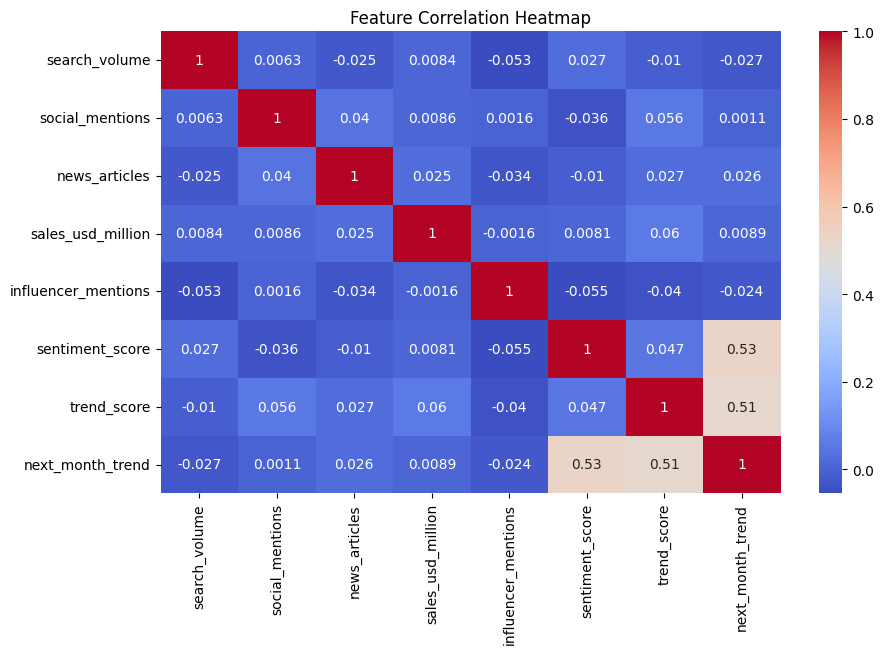

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


/tmp/ipython-input-3070222384.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='next_month_trend', data=train_df, palette='cool')


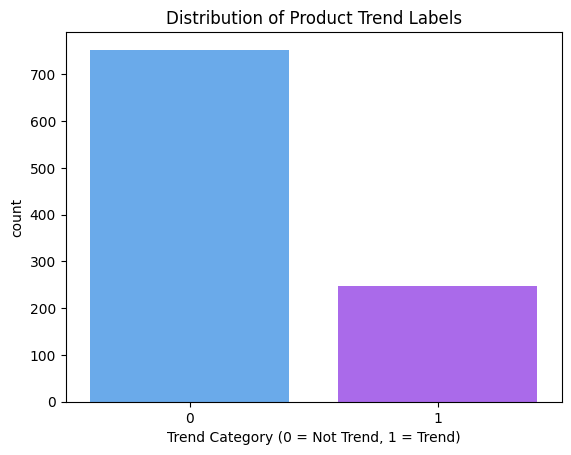

In [ ]:
sns.countplot(x='next_month_trend', data=train_df, palette='cool')
plt.title("Distribution of Product Trend Labels")
plt.xlabel("Trend Category (0 = Not Trend, 1 = Trend)")
plt.show()


In [ ]:
for df in [train_df, test_df]:
    df['social_to_search_ratio'] = df['social_mentions'] / (df['search_volume'] + 1)
    df['investment_per_mention'] = df['sales_usd_million'] / (df['social_mentions'] + 1)  #
    df['overall_engagement'] = (df['search_volume'] + df['social_mentions'] + df['influencer_mentions']) / 3


5-Fold CV Accuracy Scores: [0.995 1.    0.995 0.995 0.995]
Mean CV Accuracy: 0.9960000000000001

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       1.00      0.96      0.98        74

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300

ROC AUC: 0.999940205692418


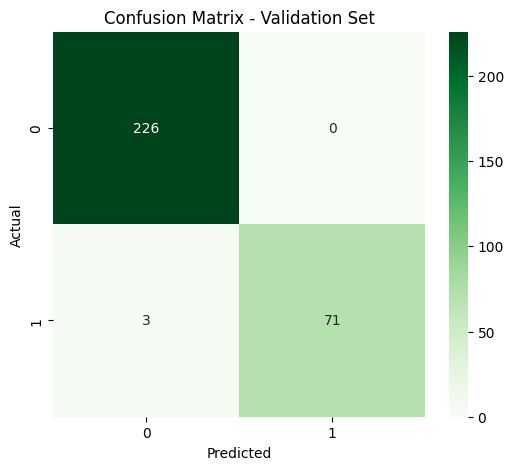

/tmp/ipython-input-3046894039.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


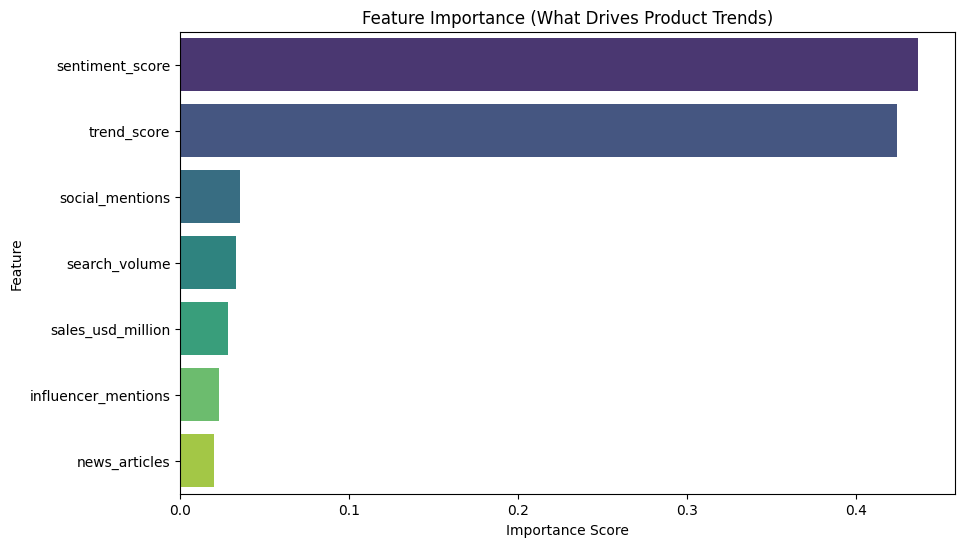

/tmp/ipython-input-3046894039.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='trend_score', y='product_name', data=top_products, palette='cool')


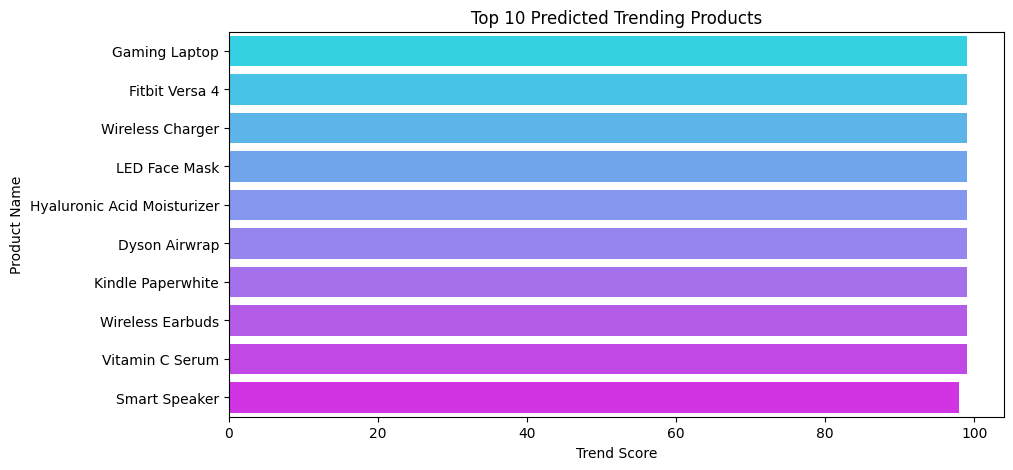

/tmp/ipython-input-3046894039.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='predicted_trend', y='count', data=trend_summary, palette='magma')


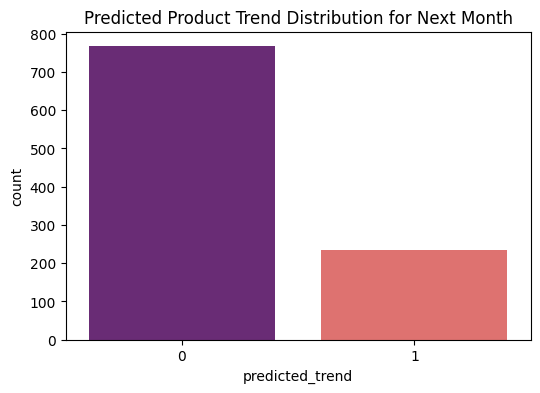

In [ ]:

for df in [train_df, test_df]:
    # Engagement metrics
    df['social_to_search_ratio'] = df['social_mentions'] / (df['search_volume'] + 1)
    df['overall_engagement'] = (df['search_volume'] + df['social_mentions'] + df['influencer_mentions']) / 3


for df in [train_df, test_df]:
    df.fillna(df.mean(numeric_only=True), inplace=True)

features = ['search_volume','social_mentions','news_articles','sales_usd_million',
            'influencer_mentions','sentiment_score','trend_score']  # core features
target = 'next_month_trend'

X = train_df[features]
y = train_df[target]


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=3,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
rf.fit(X_train, y_train)

cv_scores = cross_val_score(rf, X, y, cv=5)
print("5-Fold CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

y_pred = rf.predict(X_val)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title("Feature Importance (What Drives Product Trends)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# -----------------------------
# 🔟 Predictions on test set
# -----------------------------
test_df['predicted_trend'] = rf.predict(test_df[features])

# Top 10 Predicted Trending Products
top_products = test_df[test_df['predicted_trend']==1].sort_values(by='trend_score', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x='trend_score', y='product_name', data=top_products, palette='cool')
plt.title("Top 10 Predicted Trending Products")
plt.xlabel("Trend Score")
plt.ylabel("Product Name")
plt.show()

# Predicted Trend Distribution
trend_summary = test_df.groupby('predicted_trend').size().reset_index(name='count')
plt.figure(figsize=(6,4))
sns.barplot(x='predicted_trend', y='count', data=trend_summary, palette='magma')
plt.title("Predicted Product Trend Distribution for Next Month")
plt.show()
